In [1]:
import pypsa
import pandas as pd
import numpy as np
import yaml
import sys
import os
import yaml

sys.path.append(os.path.abspath("../pypsa-eur-resilient/config"))
sys.path.append(os.path.abspath("../pypsa-eur-resilient/scripts"))

In [2]:
# open config yaml
RESULTS = os.path.abspath("../pypsa-eur-resilient/results") + "/"
config = yaml.safe_load(open("../pypsa-eur-resilient/config/first-run.config.yaml", "r"))
prefix = config["run"]["prefix"]
runs = config["run"]["name"]
columns = config["solve_operations"]["columns"]
planning_horizons = config["scenario"]["planning_horizons"]
clusters = config["scenario"]["clusters"][0]
opts = config["scenario"]["opts"][0]
sector_opts = config["scenario"]["sector_opts"][0]

In [3]:
networks = dict()

for run in runs:
    for planning_horizon in planning_horizons:
        print(f"Loading investment run: {run} {planning_horizon}...")
        n_inv = pypsa.Network(f"{RESULTS}/{prefix}/{run}/networks/base_s_{clusters}_{opts}_{sector_opts}_{planning_horizon}.nc")
        networks[(run, planning_horizon)] = n_inv

print("")

Loading investment run: pcipmi 2030...


INFO:pypsa.io:Imported network base_s_70___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: pcipmi 2040...


INFO:pypsa.io:Imported network base_s_70___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: pcipmi 2050...


INFO:pypsa.io:Imported network base_s_70___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: pcipmi-delay-10years 2030...


INFO:pypsa.io:Imported network base_s_70___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: pcipmi-delay-10years 2040...


INFO:pypsa.io:Imported network base_s_70___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: pcipmi-delay-10years 2050...


INFO:pypsa.io:Imported network base_s_70___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: pcipmi-national-expansion 2030...


INFO:pypsa.io:Imported network base_s_70___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: pcipmi-national-expansion 2040...


INFO:pypsa.io:Imported network base_s_70___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: pcipmi-national-expansion 2050...


INFO:pypsa.io:Imported network base_s_70___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: pcipmi-national-international-expansion 2030...


INFO:pypsa.io:Imported network base_s_70___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: pcipmi-national-international-expansion 2040...


INFO:pypsa.io:Imported network base_s_70___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: pcipmi-national-international-expansion 2050...


INFO:pypsa.io:Imported network base_s_70___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: no-pipelines 2030...


INFO:pypsa.io:Imported network base_s_70___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: no-pipelines 2040...


INFO:pypsa.io:Imported network base_s_70___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: no-pipelines 2050...


INFO:pypsa.io:Imported network base_s_70___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: greenfield-pipelines 2030...


INFO:pypsa.io:Imported network base_s_70___2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: greenfield-pipelines 2040...


INFO:pypsa.io:Imported network base_s_70___2040.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


Loading investment run: greenfield-pipelines 2050...


INFO:pypsa.io:Imported network base_s_70___2050.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [90]:
# Create table of CAPEX
capex = pd.DataFrame(
    index=runs,
    columns=planning_horizons,
    dtype=float,
)

for row in runs:
    for planning_horizon in planning_horizons:
        n = networks[(row, planning_horizon)]
        value = n.statistics.capex().sum()
        # get all components
        capex.loc[row, planning_horizon] = value / 1e9 # bn. EUR 

# Create table of OPEX
opex = pd.DataFrame(
    index=runs,
    columns=planning_horizons,
    dtype=float,
)

for row in runs:
    for planning_horizon in planning_horizons:
        n = networks[(row, planning_horizon)]
        value = n.statistics.opex().sum()
        # get all components
        opex.loc[row, planning_horizon] = value / 1e9 # bn. EUR

# TOTEX
totex = capex + opex

# TOTEX over all years and interpolate
totex_sum = pd.DataFrame(
    index=totex.index,
    columns=["All years until 2075"],
    dtype=float,
)

totex_sum["All years until 2075"] = 10 * totex[2030] + 10 * totex[2040] + 25 * totex[2050]
totex_sum.sort_values(
    by="All years until 2075",
    ascending=False,
    inplace=True,
)

# Sort by TOTEX over lifetime, reindex
capex = capex.loc[totex_sum.index]
opex = opex.loc[totex_sum.index]
totex = totex.loc[totex_sum.index]

# print("### CAPEX in bn. EUR ###")
# print(capex.round(2).to_string())
# print("") 

# print("### OPEX in bn. EUR ###")
# print(opex.round(2).to_string())

In [93]:
capex

,2030,2040,2050
pcipmi,517.087558,782.937557,800.172340
pcipmi-national-expansion,517.277347,777.719222,793.108690
pcipmi-delay-10years,496.219737,776.385695,800.202466
pcipmi-national-international-expansion,516.422863,767.569914,785.643789
greenfield-pipelines,510.324786,762.805196,782.343903
no-pipelines,495.313988,778.519342,790.805392


In [94]:
opex

,2030,2040,2050
pcipmi,370.940470,180.487711,88.057678
pcipmi-national-expansion,370.511448,180.439740,89.362088
pcipmi-delay-10years,369.333018,180.455062,88.283879
pcipmi-national-international-expansion,370.989204,181.165729,89.389695
greenfield-pipelines,370.800806,181.213022,88.666910
no-pipelines,369.511487,174.141524,82.912623


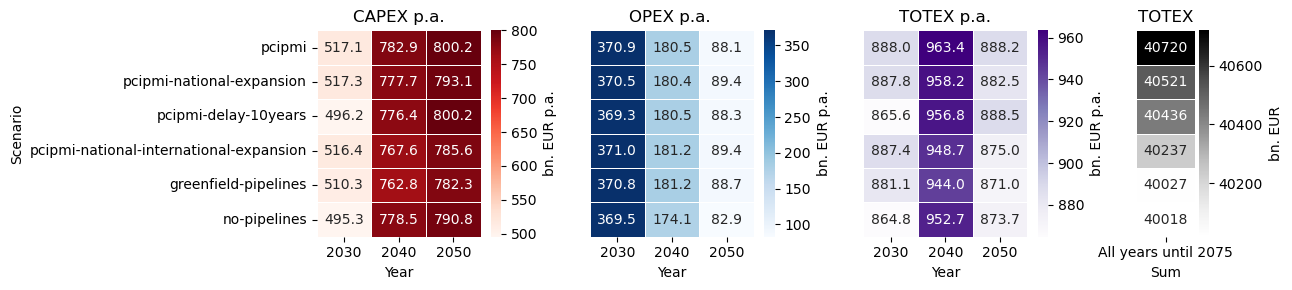

In [95]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Reorder dfs
capex = capex.reindex(totex_sum.index)

fig = plt.figure(figsize=(13, 3))

# Define grid layout with width ratios
gs = gridspec.GridSpec(1, 4, width_ratios=[7, 7, 7, 2.5], figure=fig)

# Create axes from the GridSpec
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1], sharey=ax1)
ax3 = fig.add_subplot(gs[2], sharey=ax1)
ax4 = fig.add_subplot(gs[3], sharey=ax1)

for ax in [ax2, ax3, ax4]:
    ax.tick_params(left=False, labelleft=False)

# CAPEX
sns.heatmap(capex, annot=True, cmap="Reds", fmt=".1f", linewidths=0.5,
            cbar_kws={"label": "bn. EUR p.a."}, ax=ax1)
ax1.set_title("CAPEX p.a.")
ax1.set_xlabel("Year")
ax1.set_ylabel("Scenario")

# OPEX
sns.heatmap(opex, annot=True, cmap="Blues", fmt=".1f", linewidths=0.5,
            cbar_kws={"label": "bn. EUR p.a."}, ax=ax2)
ax2.set_title("OPEX p.a. ")
ax2.set_xlabel("Year")
ax2.set_ylabel("")  # Don't repeat "Scenario" if sharing y-axis

sns.heatmap(totex, annot=True, cmap="Purples", fmt=".1f", linewidths=0.5,
            cbar_kws={"label": "bn. EUR p.a."}, ax=ax3)
ax3.set_title("TOTEX p.a.")
ax3.set_xlabel("Year")
ax3.set_ylabel("")  # Don't repeat "Scenario" if sharing y-axis


sns.heatmap(totex_sum, annot=True, cmap="Greys", fmt=".0f", linewidths=0.5,
            cbar_kws={"label": "bn. EUR"}, ax=ax4)
ax4.set_title("TOTEX")
ax4.set_xlabel("Sum")
ax4.set_ylabel("")  # Don't repeat "Scenario" if sharing y-axis

plt.subplots_adjust(wspace=0.1) 

# Sort x axis of all plots by totex_sum.index
ax

plt.tight_layout()
plt.show()

In [105]:
n = networks[("pcipmi", 2040)]

In [108]:
n.statistics.expanded_capacity().sum() + n.statistics.installed_capacity().sum()

2397406624.6480002

In [103]:
networks[('pcipmi', 2040)].statistics.installed_capacity().sum()

1538197280.4504502

In [98]:
networks[('pcipmi', 2040)].statistics.optimal_capacity().sum()

2397406624.648

**Notes on system costs**
- `no-pipelines` is the cheapest over the assets' lifetime, limit build-out rate of renewables?
- check DAC, costs, cross compare with carbon networks paper
- why no pipelines so much cheaper in 2030, should be more expensive
- co2 pipeline cost check
- compare with old run